In [1]:
%matplotlib widget
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_bvp, solve_ivp
from EOS import NeutronStarEOS

In [2]:
Msun = 1.988e33
G = 6.6743e-8
c = 3e10

In [3]:
apr_eos = NeutronStarEOS('APR')

In [4]:
def GR_create_boundary_conditions(eos_class, rho_c, ri):

    P = eos_class.get_pressure()
    dPdrho = eos_class.dP_dRho()
    rho_initial = rho_c - 228.917 * ri**2
    m_initial = 4.18879e14 * ri**3

    def boundary_conditions(ya, yb):
        return np.array([
            ya[0] - rho_initial,                 
            ya[1] - m_initial,                 
        ])
    
    return boundary_conditions, rho_initial, m_initial


In [30]:
"""    if not flag:
        expr_TOV = - (G / c**2) / r**2 * (rho * c**2 + P(rho)) * (mass + (4 * np.pi * r**3 * P(rho) / c**2)) / (1 - 2 * G * mass/(r * c**2))
        expr_TOV /= dPdRho(rho)
        drhodr = expr_TOV
        dmdr = 4 * np.pi * r**2 * rho
    else: 
        drhodr = 0
        dmdr=0"""

'    if not flag:\n        expr_TOV = - (G / c**2) / r**2 * (rho * c**2 + P(rho)) * (mass + (4 * np.pi * r**3 * P(rho) / c**2)) / (1 - 2 * G * mass/(r * c**2))\n        expr_TOV /= dPdRho(rho)\n        drhodr = expr_TOV\n        dmdr = 4 * np.pi * r**2 * rho\n    else: \n        drhodr = 0\n        dmdr=0'

In [5]:
ri = 1e-15
rho_c = 1e15
boundary_conditions_func, rho_initial, mass_initial = GR_create_boundary_conditions(
    eos_class=apr_eos,
    rho_c=rho_c,
    ri=ri
)
print(boundary_conditions_func)
print(f"rho_initial:{rho_initial:0.2e}")
print(f"mass_initial= {mass_initial:0.2e}")

<function GR_create_boundary_conditions.<locals>.boundary_conditions at 0x10440eac0>
rho_initial:1.00e+15
mass_initial= 4.19e-31


In [32]:
# Define the domain for r
rf = 2e6 # right below the expected radius to debug the code first
start_order = int(np.log10(ri))
end_order = int(np.log10(rf))
points_per_order = 1500  # Adjust the number of points per order of magnitude

# Create a single array with the desired number of points per order of magnitude
#r = np.logspace(start_order, end_order, (end_order - start_order) * points_per_order, endpoint=True)
r_original = np.logspace(start_order, end_order, (end_order - start_order) * points_per_order)
r_dense = np.logspace(end_order, np.log10(rf), 1500)

# Combine the meshes
r = np.unique(np.concatenate((r_original, r_dense)))

print(len(r))

32999


# 1) BVP Approach

In [8]:
"""
To Do:
1) Setup class such that
    i) drhodr and dmdr are only initialized once
    ii) if rho<1: set rho=0 
    iii) update TOV only for non-zero rhos
    iv) repeat till TOV is solved through solve_bvp
"""
# global variables
first_call = True
global_drhodr = None
global_dmdr = None

class GR_ode_class:
    def __init__(self, P, dPdRho):
        #self.first_call = True
        global global_drhodr, global_dmdr
        self.P = P
        self.dPdRho = dPdRho
        #self.G = G
        #self.c = c

    def update(self, r, y):
        global global_drhodr, global_dmdr, first_call
        rho, mass = y
        current_size = len(r)
        global_drhodr = np.resize(global_drhodr, current_size)
        global_dmdr = np.resize(global_dmdr, current_size)
        #print(f"\nlen(rho) = {len(rho)}")
        #print(f"len(r) = {len(r)}")
        #print(f"len(mass) = {len(mass)}\n")
        if first_call:
            # Initial computation for drhodr and dmdr
            global_drhodr = - (G / c**2) / r**2 * (rho * c**2 + self.P(rho)) * (mass + (4 * np.pi * r**3 * self.P(rho) / c**2)) / (1 - 2 * G * mass/(r * c**2)) \
                /self.dPdRho(rho) # Your initial derivative calculation for drhodr
            global_dmdr = 4 * np.pi * r**2 * rho   # Your initial derivative calculation for dmdr
            first_call = False
            #print('Passed in self.first_call')
            #print(f" Last 10 rhos = {rho[-10:]}")
            #print(f"len(global_drhodr) = {len(global_drhodr)}")
            #print(f"len(global_dmdr) = {len(global_dmdr)}\n")
        else:
            # Find indices where rho is less than 1 and update
            #print("Looking for rho <1\n")
            #print(f"\nlen(rho) = {len(rho)}")
            #print(f"len(r) = {len(r)}")
            #print(f"len(mass) = {len(mass)}\n")
            #print(f"len(global_drhodr) = {len(global_drhodr)}")
            #print(f"len(global_dmdr) = {len(global_dmdr)}\n")
            indices = np.where(rho < 1)
            if len(indices)>=2:
                print('found rho<1')
            rho[indices] = 1
            #global_drhodr[indices] = -1e13
            #global_dmdr[indices] = 1e30
    
            non_zero_indices = np.where(rho >= 1)
            if len(non_zero_indices)>=2:
                valid_rho = rho[non_zero_indices]
                valid_mass = mass[non_zero_indices]
                #print('valid_rho[-5:] = ', valid_rho[-5:])
                expr_TOV = - (G / c**2) / r**2 * (valid_rho * c**2 + self.P(valid_rho)) * (valid_mass + (4 * np.pi * r**3 * self.P(valid_rho) / c**2)) / (1 - 2 * G * valid_mass/(r * c**2))
                expr_TOV /= self.dPdRho(valid_rho)
                global_drhodr[non_zero_indices] = expr_TOV
                global_dmdr[non_zero_indices] = 4 * np.pi * r**2 * valid_rho

        return np.array([global_drhodr, global_dmdr])



In [8]:
# Define the initial guess for the solution
y_initial = np.zeros((2, r.size))  # Initialize the array with zeros

idx_1_km =  np.argmax(r >= 1.2e5) # solution should increase around here
# set the first value of a(r) to ac
# rho should be constant for a long distance and then decreases right before the radius
y_initial[0, :idx_1_km] = rho_initial  # rho(r) 
y_initial[0, idx_1_km:] = np.linspace(rho_initial, 1.1, len(y_initial[0,idx_1_km:]))
y_initial[1,:] = np.logspace(-31, 33, len(y_initial[1,:]))

In [9]:
# the system need to be wrapped since solve_bvp expects the ode
# function to be only function of (independent, dependent) variables

def bvp_ode_system_wrapper(r, y):
    GR_ode_system = GR_ode_class(P=apr_eos.get_pressure(), dPdRho=apr_eos.dP_dRho())
    return GR_ode_system.update(r,y)

In [10]:
# Solve the BVP
sol = solve_bvp(bvp_ode_system_wrapper, boundary_conditions_func, r, y_initial, max_nodes=40000, verbose=2, tol=0.1)

# Process the solution
rho = sol.sol(r)[0]
mass = sol.sol(r)[1]




# Check if the solution is successful and process it
if sol.success:
    print('Solution found!')
else:
    print("Solution was not successful.")

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.22e+02       1.41e-29         32999          5213      
       2          9.26e+02       8.50e-26         38212         (7266)     
Number of nodes is exceeded after iteration 2. 
Maximum relative residual: 9.26e+02 
Maximum boundary residual: 8.50e-26
Solution was not successful.


# 2) IVP Approach

In [11]:
rf = 3e6
def GR_ode_system(r ,y ,P ,dPdRho):
    rho, mass = y
    if rho < 1:
        return np.array([0,0])

    expr_TOV = - (G / c**2) / r**2 * (rho * c**2 + P(rho)) * (mass + (4 * np.pi * r**3 * P(rho) / c**2)) / (1 - 2 * G * mass/(r * c**2))
    expr_TOV /= dPdRho(rho)

    drhodr = expr_TOV

    dmdr = 4 * np.pi * r**2 * rho

    return np.array([drhodr, dmdr])

def ivp_system_wrapper(r, y):
    P = apr_eos.get_pressure()
    dPdRho = apr_eos.dP_dRho()
    return GR_ode_system(r ,y ,P ,dPdRho)

In [12]:
sol_ivp = solve_ivp(ivp_system_wrapper, (ri,rf), [rho_initial, mass_initial], method='RK45')

In [13]:
r_values = sol_ivp.t
rho_values, mass_values = sol_ivp.y

In [14]:
rho_values[-30:]

array([1.24952870e+03, 5.11451228e+02, 2.36948010e+02, 1.20232169e+02,
       6.51493515e+01, 3.69714485e+01, 2.16568242e+01, 1.29725584e+01,
       7.91795695e+00, 4.93051262e+00, 3.13854686e+00, 2.04216115e+00,
       1.36013591e+00, 1.03484530e+00, 9.89030288e-01, 9.89030288e-01,
       9.89030288e-01, 9.89030288e-01, 9.89030288e-01, 9.89030288e-01,
       9.89030288e-01, 9.89030288e-01, 9.89030288e-01, 9.89030288e-01,
       9.89030288e-01, 9.89030288e-01, 9.89030288e-01, 9.89030288e-01,
       9.89030288e-01, 9.89030288e-01])

In [15]:
idx_outside = np.argmin(rho_values)
radius_ns = r_values[idx_outside]
mass_ns = mass_values[idx_outside]
print(f"The star has mass = {mass_ns/Msun:0.3} Msun and radius = {radius_ns/1e5:0.3} km")

The star has mass = 1.43 Msun and radius = 11.4 km


# 3) Plotting

In [16]:
def plot_somethin(y, x, y_label, x_label=r'$r(km)$', y_scale=None, debug=False):
    plt.figure(figsize=(8, 4))
    plt.plot(x/1e5, y, color='blue', label = 'BVP')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if debug:
       plt.xlim(x[-700]/1e5,x[-1]/1e5) 
    else:
        plt.xscale('log')
    if y_scale=='log':
        plt.yscale('log')
    plt.axvline(x=1e6/1e5, linestyle='--', color='grey', linewidth=0.4,zorder=-1)
    
    return plt.show()

In [21]:
rho_values

array([1.00000000e+15, 1.00000000e+15, 1.00000000e+15, 1.00000000e+15,
       1.00000000e+15, 1.00000000e+15, 1.00000000e+15, 1.00000001e+15,
       1.00000069e+15, 1.00004402e+15, 1.00072058e+15, 1.00554963e+15,
       1.02752459e+15, 1.10705351e+15, 1.43241898e+15, 1.91933597e+15,
       2.27365615e+15, 3.30599397e+15, 4.74978087e+15, 6.05692688e+15,
       9.31667591e+15, 1.33686004e+16, 1.60175927e+16, 2.16720897e+16,
       3.07736112e+16, 3.47371941e+16, 4.10438907e+16, 5.19215183e+16,
       8.84063698e+16, 1.39867111e+17, 1.98662442e+17, 2.24279065e+17,
       2.64893977e+17, 3.01004488e+17, 3.59985988e+17, 4.09640235e+17,
       4.91297993e+17, 5.58921845e+17, 6.70071016e+17, 7.61755944e+17,
       9.12095531e+17, 1.03612804e+18, 1.23903729e+18, 1.40664130e+18,
       1.68034722e+18, 1.90669567e+18, 2.27589649e+18, 2.58148240e+18,
       3.07956819e+18, 3.49205904e+18, 4.16412706e+18, 5.20683703e+18,
       8.35842456e+18, 1.15577045e+19, 1.33882424e+19, 1.67181926e+19,
      

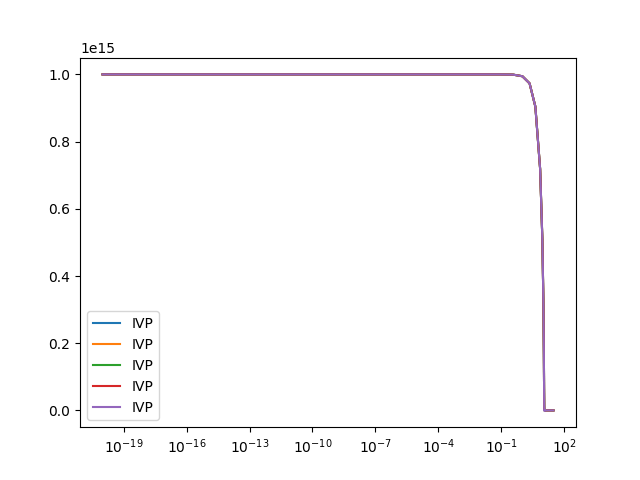

In [26]:
%matplotlib widget
#plot_somethin(rho, r, y_label=r"$\rho (g/cm^{3}) $")
plt.plot(r_values/1e5, rho_values, label='IVP')
plt.xscale('log')
plt.legend()
plt.show()

In [22]:
plot_somethin(mass/Msun, r, y_label=r"$M/M_{\odot} $")
plt.plot(r_values/1e5, mass_values/Msun, label='IVP')
plt.xscale('log')
plt.legend()

NameError: name 'mass' is not defined